## Investigating the relationship between cloud-top height and precipitation in the trade-wind region (ATOMIC)

### Python packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob, os, re
import pandas as pd
from datetime import datetime

### Functions

In [2]:
def extract_yyyydoy(fpath):
    """
    Return integer YYYYDOY if found in the basename of fpath; else None.
    """
    fname = os.path.basename(fpath)
    m = doy_pattern.search(fname)
    return int(m.group(1)) if m else None

def extract_hhmm(fpath):
    """
    Return 4-digit HHMM if found (as the group after YYYYDOY); else "0000".
    """
    fname = os.path.basename(fpath)
    m = time_pattern.search(fname)
    return m.group(2) if m else "0000"

def add_time_coord(ds):
    # Build timestamp from global attrs
    yyyydoy = str(ds.attrs["YYYYDOY"])  # e.g., "2020015"
    hhmm    = str(ds.attrs["HHMM"])     # e.g., "2100"

    year = int(yyyydoy[:4])
    doy  = int(yyyydoy[-3:])
    hour = int(hhmm[:2])
    minute = int(hhmm[2:])
    ts = datetime.strptime(f"{year} {doy} {hour} {minute}", "%Y %j %H %M")

    # mark spatial coords
    ds = ds.set_coords(["latitude", "longitude"])

    # If 'time' dim already exists, just set its value; else create it
    if "time" in ds.dims:
        ds = ds.assign_coords(time=[ts])
    else:
        ds = ds.expand_dims({"time": [ts]})

    return ds

def imerg_start_dt(path):
    m = imerg_re.search(os.path.basename(path))
    if not m:
        return None
    ymd, S, _ = m.groups()
    return datetime.strptime(ymd + S, "%Y%m%d%H%M%S")  # start time

### Loading data: GOES-16 regridded cloud-top height

In [3]:
# Time range
start_doy = 2020015  # 015 January 15, 2020
end_doy   = 2020050  # 050 February 19, 2020

# Base directory
base_dir = '/home/huangany/data/KloudatA/GOES-16/2020/regrid'

# Regex to extract the 7-digit YYYYDOY and 4-digit HHMM from each filename
doy_pattern  = re.compile(r'(\d{7})\.\d{4}')
time_pattern = re.compile(r'\.(\d{7})\.(\d{4})\.')

# Gather & filter all .NC files by DOY range
all_files = sorted(glob.glob(os.path.join(base_dir, '**', '*.NC'), recursive=True))
filtered_files = [
    f for f in all_files
    if (extract_yyyydoy(f) is not None) and (start_doy <= extract_yyyydoy(f) <= end_doy)
]

# Keep only files that are exactly on the hour (HHMM ends with '00')
filtered_files = [
    f for f in filtered_files
    if (extract_hhmm(f) is not None) and extract_hhmm(f).endswith('00')
]

# Ensure file order is chronological by attrs in the name
filtered_files = sorted(filtered_files, key=lambda f: (extract_yyyydoy(f), extract_hhmm(f)))

# Load all hourly files into one Dataset
dsg = xr.open_mfdataset(
    filtered_files,
    combine="nested",      # we’re concatenating along a new dim explicitly
    concat_dim="time",
    preprocess=add_time_coord,
    parallel=True
)

### Loading data: IMERG precipitation

In [4]:
# Time range: based on GOES data
goes_times = pd.to_datetime(dsg.time.values)         # dsg is your GOES dataset
goes_hours = set(goes_times.strftime("%Y%m%d%H"))    # e.g., '2020011611'

# Parse IMERG start time from filename (YYYYMMDD + S HHMMSS)
imerg_re = re.compile(r'\.(\d{8})-S(\d{6})-E(\d{6})')

# Gather IMERG files in the GOES time span and keep exact-hour matches
imerg_base = "/home/huangany/data/KloudatA/IMERG/30-min"
tmin, tmax = goes_times.min(), goes_times.max()

# Limit search to needed years/months (simple: glob recursively under those years)
years = sorted({tmin.year, tmax.year})
imerg_candidates = []
for y in years:
    imerg_candidates += glob.glob(os.path.join(imerg_base, f"{y:04d}", "**", "*.nc4"), recursive=True)

imerg_pairs = []
for f in imerg_candidates:
    dt = imerg_start_dt(f)
    if dt is None:
        continue
    ts = pd.Timestamp(dt)
    if not (tmin <= ts <= tmax):
        continue
    # keep only files starting exactly at HH:00:00 AND matching a GOES hour
    if dt.minute == 0 and dt.second == 0 and dt.strftime("%Y%m%d%H") in goes_hours:
        imerg_pairs.append((dt, f))

imerg_pairs.sort(key=lambda x: x[0])
imerg_files = [f for _, f in imerg_pairs]

dsi = xr.open_mfdataset(
    imerg_files,
    combine="by_coords",      # time, lon, lat are real coords in IMERG
    parallel=True
)

### Test plot

In [5]:
lon_min, lon_max = -60.05, -48.95
lat_min, lat_max = 12.45, 16.05

tt = 135
lon = dsg.longitude
lat = dsg.latitude

cth = dsg.cloud_top_height.isel(time=tt).squeeze()
pre = dsi.precipitation.isel(time=tt).sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).squeeze().T
print(dsg.time.isel(time=tt))
time_str = pd.to_datetime(dsg.time.isel(time=tt).values).strftime("%Y-%m-%d %H:%M UTC")

cth = np.where(cth<0.5, np.nan, cth)
pre = np.where(pre==0, np.nan, pre)

<xarray.DataArray 'time' ()> Size: 8B
array('2020-01-27T14:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-01-27T14:00:00


/tmp/ipykernel_3114477/3097710186.py:4: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_3114477/3097710186.py:10: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


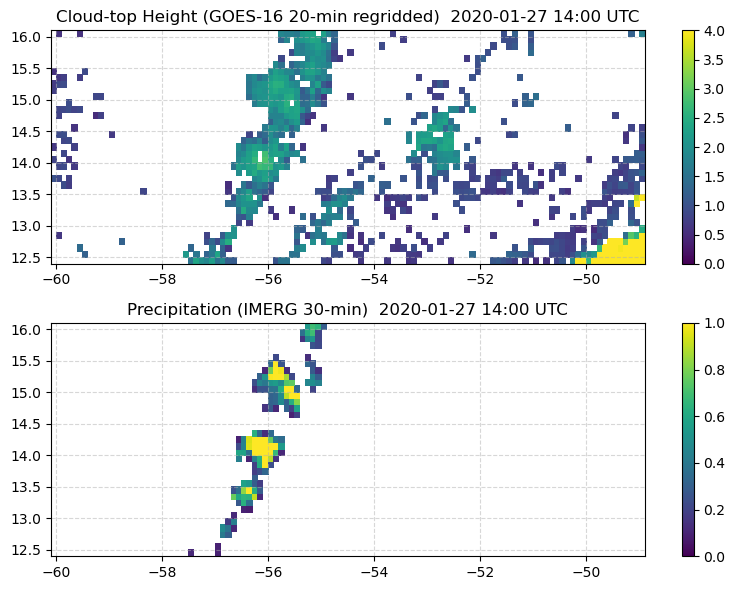

In [6]:
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.pcolor(lon, lat, cth, vmin=0, vmax=4)
plt.colorbar()
plt.title(f'Cloud-top Height (GOES-16 20-min regridded)  {time_str}')
plt.grid(linestyle='--', alpha=0.5)

plt.subplot(2,1,2)
plt.pcolor(lon, lat, pre, vmin=0, vmax=1)
plt.colorbar()
plt.title(f'Precipitation (IMERG 30-min)  {time_str}')
plt.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Calculations

In [7]:
lon_min, lon_max = -60.05, -48.95
lat_min, lat_max = 12.45, 16.05
nt = len(filtered_files)
cth_bins = np.arange(0, 20.01, 0.1)
n_bins = len(cth_bins)

pre_avg = np.full((nt, n_bins), np.nan, dtype=float)
for it in range(nt):
    cth = dsg.cloud_top_height.isel(time=it).squeeze()
    pre = dsi.precipitation.isel(time=it).sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).squeeze().transpose("lat", "lon")

    # Get NumPy arrays and flatten
    cth_flat = np.asarray(cth).ravel()
    pre_flat = np.asarray(pre).ravel()

    # Mask invalids (NaNs); optionally also drop very small precip or cth<0.5 km
    mask = np.isfinite(cth_flat) & np.isfinite(pre_flat) #& (cth_flat >= 0.5)
    # mask &= (cth_flat >= 0.5)      # uncomment if you want CTH >= 0.5 km only
    # mask &= (pre_flat > 0)         # uncomment if you want precip > 0 only

    pre_flat = pre_flat[mask]
    cth_flat = cth_flat[mask]

    # Digitize cth into bins
    inds = np.digitize(cth_flat, cth_bins) - 1
    valid_inds = (inds >= 0) & (inds < n_bins)
    inds = inds[valid_inds]
    pre_vals = pre_flat[valid_inds]

    bin_sums   = np.bincount(inds, weights=pre_vals, minlength=n_bins)
    bin_counts = np.bincount(inds, minlength=n_bins)
    with np.errstate(invalid='ignore', divide='ignore'):
        pre_avg[it, :] = bin_sums / bin_counts


### Plot

In [8]:
Lv = 2.5e+6 # Latent heat of vaporization [J/kg]
rho_sfc = 1.16   # Surface density [kg/m^3]
pre_avg = pre_avg * Lv * rho_sfc / 3600 # [W/m^2]

/tmp/ipykernel_3114477/2432155893.py:13: RuntimeWarning: Mean of empty slice
  mean_pre = np.nanmean(pre_avg, axis=0)


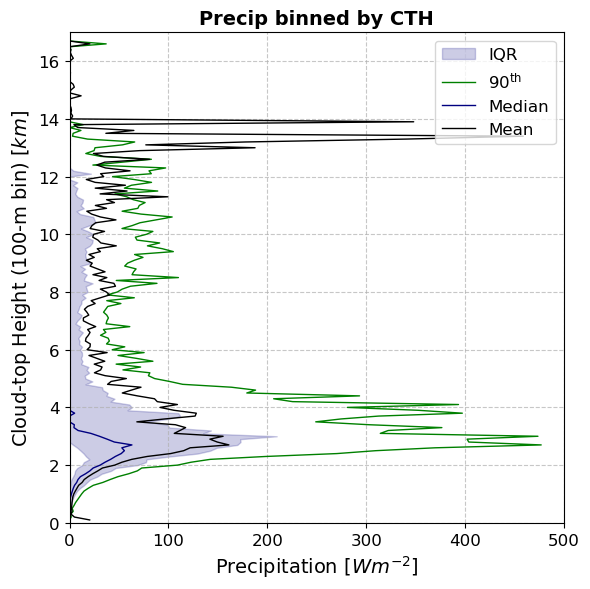

In [14]:
plt.figure(figsize=(6, 6))  # a slightly taller figure to accommodate two panels

# Calculate 25th and 75th percentiles along the time dimension
pre_p25 = np.nanpercentile(pre_avg, 25, axis=0)
pre_p50 = np.nanpercentile(pre_avg, 50, axis=0)
pre_p75 = np.nanpercentile(pre_avg, 75, axis=0)
pre_p90 = np.nanpercentile(pre_avg, 90, axis=0)

# Fill between the 25th and 75th percentiles
plt.fill_betweenx(cth_bins, pre_p25, pre_p75, color='navy', alpha=0.2, label='IQR', linewidth=1)

# Overplot the time‐mean profile in black
mean_pre = np.nanmean(pre_avg, axis=0)
plt.plot(pre_p90, cth_bins, color='green', linewidth=1, label=r'$90^{\mathrm{th}}$')
plt.plot(pre_p50, cth_bins, color='navy', linewidth=1, label='Median')
plt.plot(mean_pre, cth_bins, color='black', linewidth=1, label='Mean')

plt.xlim(0, 500)
plt.ylim(0, 17)
plt.title(f'Precip binned by CTH', fontsize=14, fontweight='bold')
plt.ylabel(r'Cloud-top Height (100-m bin) [$km$]', fontsize=14)
plt.xlabel(r'Precipitation [$Wm^{-2}$]', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

In [10]:
ppp = np.arange(0, 550, 50)
pppw = np.round(ppp * 3600 / (Lv * rho_sfc), 2)
ppp, pppw

(array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500]),
 array([0.  , 0.06, 0.12, 0.19, 0.25, 0.31, 0.37, 0.43, 0.5 , 0.56, 0.62]))

In [11]:
dsi.precipitation.values.mean()

0.072656535

In [12]:
dsi.precipitation.values.mean() * Lv * rho_sfc / 3600

58.52887510425515